In [138]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import zipfile
import io
import pandas as pd
import math
from IPython.display import display
from collections import defaultdict

zipped_data_path = "../data/clean_data/class-competition-cleaned.zip"

dataframes = defaultdict(pd.DataFrame)
with zipfile.ZipFile(zipped_data_path, "r") as zipf:
    for filename in zipf.namelist():
        if filename.endswith(".csv"):
            with zipf.open(filename) as f:
                dataframes.update({ filename : pd.read_csv(io.TextIOWrapper(f)) })

                # Lets take a look at the files
                print(f"FILE: {filename}")
                # If you want to see file info uncomment this:
                # display(dataframes[filename].info())
                # display(dataframes[filename].head())

FILE: train_call_type_A.csv
FILE: train_call_type_B.csv
FILE: train_call_type_C.csv
FILE: test_public.csv


In [139]:
train_data_A = dataframes["train_call_type_A.csv"]
train_data_B = dataframes["train_call_type_B.csv"]
train_data_C = dataframes["train_call_type_C.csv"]
test_data  = dataframes["test_public.csv"]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [140]:
from sklearn.preprocessing import StandardScaler

# Split the START_LOCATION into two new columns for latitude and longitude for train set
for i, j in train_data_B['START_LOCATION'].items():
    split = j.split(',')
    train_data_B.at[i, 'START_LAT'] = split[0]
    train_data_B.at[i, 'START_LONG'] = split[1]

# Use only data points with CALL_TYPE B
# Split the START_LOCATION into two new columns for latitude and longitude for test set
for i, j in test_data['START_LOCATION'].items():
    if not isinstance(j, str):
        test_data.at[i, 'START_LAT'] = 41.1564349 # MEAN
        test_data.at[i, 'START_LONG'] = -8.61451627 # MEAN
    else:
        split = j.split(',')
        test_data.at[i, 'START_LAT'] = split[0]
        test_data.at[i, 'START_LONG'] = split[1]

latitude_train = pd.DataFrame(train_data_B['START_LAT'].astype(float))
longitude_train = pd.DataFrame(train_data_B['START_LONG'].astype(float))
latitude_test = pd.DataFrame(test_data['START_LAT'].astype(float))
longitude_test = pd.DataFrame(test_data['START_LONG'].astype(float))

lat_scaler = StandardScaler()
lat_scaler.fit(latitude_train)

normalized_latitude_train = lat_scaler.transform(latitude_train)
normalized_latitude_test = lat_scaler.transform(latitude_test)

long_scaler = StandardScaler()
long_scaler.fit(longitude_train)

normalized_longitude_train = long_scaler.transform(longitude_train)
normalized_longitude_test = long_scaler.transform(longitude_test)

train_data_B.loc[:, 'START_LAT_NORMALIZED'] = normalized_latitude_train
train_data_B.loc[:, 'START_LONG_NORMALIZED'] = normalized_longitude_train
test_data.loc[:, 'START_LAT_NORMALIZED'] = normalized_latitude_test
test_data.loc[:, 'START_LONG_NORMALIZED'] = normalized_longitude_test

In [141]:
merged_df = pd.merge(train_data_A.drop('START_LOCATION', axis=1), train_data_B, how='outer')
merged_df = pd.merge(merged_df, train_data_C.drop('START_LOCATION', axis=1), how='outer')

merged_df['START_LONG_NORMALIZED'].fillna(train_data_B['START_LONG_NORMALIZED'].mean(), inplace=True)
merged_df['START_LAT_NORMALIZED'].fillna(train_data_B['START_LAT_NORMALIZED'].mean(), inplace=True)

In [142]:
from sklearn.preprocessing import LabelEncoder

def encode(col, train, test):
	labelEncoder = LabelEncoder()

	train_vals, test_vals = train[col].copy(), test[col].copy()
	train_vals[np.isnan(train_vals)], test_vals[np.isnan(test_vals)] = 0, 0
	merge = pd.concat([train_vals, test_vals])

	labelEncoder.fit(merge)
	
	train[col + "_ENCODED"] = labelEncoder.transform(train_vals)
	test[col + "_ENCODED"] = labelEncoder.transform(test_vals)
	return labelEncoder

taxi_id_encoder = encode('TAXI_ID', merged_df, test_data)
origin_call_encoder = encode('ORIGIN_CALL', merged_df, test_data)
origin_stand_encoder = encode('ORIGIN_STAND', merged_df, test_data)

In [143]:
from sklearn.model_selection import train_test_split

# We could totally change this. Utilization of these just probably requires further preprocessing.
ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION = ['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'POLYLINE', 'START_LOCATION', 'TAXI_ID', 'START_LAT', 'START_LONG', 'START_LAT_NORMALIZED', 'START_LONG_NORMALIZED', 'DATE', 'YR_2013', 'MON_sin', 'MON_cos']

X = merged_df.drop("TRAVEL_TIME", axis=1)
X = X.loc[:, ~X.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]
y = merged_df["TRAVEL_TIME"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=420, shuffle=True)

test_features = test_data.loc[:, ~test_data.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]

In [144]:
y.mean()

724.7345669649628

In [145]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79116 entries, 0 to 79115
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DAY_sin               79116 non-null  float64
 1   DAY_cos               79116 non-null  float64
 2   HR_sin                79116 non-null  float64
 3   HR_cos                79116 non-null  float64
 4   WK_sin                79116 non-null  float64
 5   WK_cos                79116 non-null  float64
 6   DATE_2014-08-14       79116 non-null  bool   
 7   DATE_2014-09-30       79116 non-null  bool   
 8   DATE_2014-10-06       79116 non-null  bool   
 9   DATE_2014-10-31       79116 non-null  bool   
 10  DATE_2014-12-21       79116 non-null  bool   
 11  TAXI_ID_ENCODED       79116 non-null  int64  
 12  ORIGIN_CALL_ENCODED   79116 non-null  int64  
 13  ORIGIN_STAND_ENCODED  79116 non-null  int64  
dtypes: bool(5), float64(6), int64(3)
memory usage: 5.8 MB


In [146]:
from torch.utils.data import DataLoader, Dataset
from mlp_utils import TaxiDataset

# Separate the boolean columns
boolean_cols = ['DATE_2014-08-14','DATE_2014-09-30','DATE_2014-10-06','DATE_2014-10-31','DATE_2014-12-21']

# Separate the float columns
float_cols = ['DAY_sin', 'DAY_cos', 'HR_sin', 'HR_cos', 'WK_sin', 'WK_cos']

# Separate the encoded columns
encoded_cols = ['TAXI_ID_ENCODED', 'ORIGIN_CALL_ENCODED', 'ORIGIN_STAND_ENCODED']

# Boolean columns
train_boolean_data = X_train[boolean_cols].astype(int).values
test_boolean_data = X_test[boolean_cols].astype(int).values
test_public_boolean_data = test_features[boolean_cols].astype(int).values

# Float columns
train_float_data = X_train[float_cols].astype(float).values
test_float_data = X_test[float_cols].astype(int).values
test_public_float_data = test_features[float_cols].astype(int).values

# Encoded columns
train_encoded_data = X_train[encoded_cols].astype(int).values
test_encoded_data = X_test[encoded_cols].astype(int).values
test_public_encoded_data = test_features[encoded_cols].astype(int).values

train_concat = np.concatenate((train_boolean_data, train_float_data, train_encoded_data), axis=1)
test_concat = np.concatenate((test_boolean_data, test_float_data, test_encoded_data), axis=1)
test_public_concat = np.concatenate((test_public_boolean_data, test_public_float_data, test_public_encoded_data), axis=1)

X_train_tensor = torch.tensor(train_concat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(test_concat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)
X_test_public_tensor = torch.tensor(test_public_concat, dtype=torch.float32)

train_dataset = TaxiDataset(X_train_tensor, y_train_tensor)
test_dataset = TaxiDataset(X_test_tensor, y_test_tensor)
test_public_dataset = TaxiDataset(X_test_public_tensor)

batch_size = 64

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloader_pred = DataLoader(test_public_dataset, batch_size=batch_size)

In [147]:
import torch.nn.functional as F

class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.embed_taxi_id = nn.Embedding(len(taxi_id_encoder.classes_), 20)
    self.embed_origin_call = nn.Embedding(len(origin_call_encoder.classes_), 20)
    self.embed_origin_stand = nn.Embedding(len(origin_stand_encoder.classes_), 20)
    self.dropout1 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(71, 128)
    self.dropout2 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(128, 64)
    self.dropout3 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(64, 32)
    self.dropout4 = nn.Dropout(0.3)
    self.fc4 = nn.Linear(32, 16)
    self.fc5 = nn.Linear(16, 1)

  def forward(self, x):
    '''
      Forward pass
    '''
    taxi_id = self.embed_taxi_id(x[:, -3].to(torch.int32))
    origin_call = self.embed_origin_call(x[:, -2].to(torch.int32))
    origin_stand = self.embed_origin_stand(x[:, -1].to(torch.int32))
    x = torch.cat([taxi_id, origin_call, origin_stand, x[:, :-3]], axis=1).to(torch.float32)
    x = self.dropout1(x)
    x = F.relu(self.fc1(x))
    x = self.dropout2(x)
    x = F.relu(self.fc2(x))
    x = self.dropout3(x)
    x = F.relu(self.fc3(x))
    x = self.dropout4(x)
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x

In [148]:
from mlp_utils import num_parameters

mlp = MLP()
if torch.cuda.is_available():
    mlp.cuda()
 
num_parameters(mlp)

186257

In [149]:
from mlp_utils import pipeline
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001, weight_decay=1e-5)

train_losses, test_loss, predictions = pipeline(mlp, optimizer, dataloader_train=dataloader_train, 
                                                dataloader_test=dataloader_test, dataloader_pred=dataloader_pred,
                        			device=device, criterion=criterion, epochs=100, verbose=True)

  1%|          | 1/100 [00:04<07:11,  4.36s/it]

Epoch 1 - Train Loss = 500.22746677165657


  2%|▏         | 2/100 [00:08<06:51,  4.20s/it]

Epoch 2 - Train Loss = 458.3513192095249


  3%|▎         | 3/100 [00:12<06:41,  4.14s/it]

Epoch 3 - Train Loss = 455.1319969662534


  4%|▍         | 4/100 [00:16<06:35,  4.12s/it]

Epoch 4 - Train Loss = 451.5627657856915


  5%|▌         | 5/100 [00:20<06:32,  4.13s/it]

Epoch 5 - Train Loss = 450.13875669019853


  6%|▌         | 6/100 [00:24<06:27,  4.12s/it]

Epoch 6 - Train Loss = 447.06376875864726


  7%|▋         | 7/100 [00:28<06:22,  4.11s/it]

Epoch 7 - Train Loss = 443.2671597872483


  8%|▊         | 8/100 [00:33<06:17,  4.10s/it]

Epoch 8 - Train Loss = 441.0212883045784


  9%|▉         | 9/100 [00:37<06:14,  4.12s/it]

Epoch 9 - Train Loss = 438.1133045862411


 10%|█         | 10/100 [00:41<06:11,  4.12s/it]

Epoch 10 - Train Loss = 436.7039778249605


 11%|█         | 11/100 [00:45<06:05,  4.11s/it]

Epoch 11 - Train Loss = 435.4136116991381


 12%|█▏        | 12/100 [00:49<06:00,  4.09s/it]

Epoch 12 - Train Loss = 432.8620908877593


 13%|█▎        | 13/100 [00:53<05:54,  4.08s/it]

Epoch 13 - Train Loss = 432.3569713909381


 14%|█▍        | 14/100 [00:57<05:50,  4.08s/it]

Epoch 14 - Train Loss = 430.15356416148546


 15%|█▌        | 15/100 [01:01<05:45,  4.07s/it]

Epoch 15 - Train Loss = 428.9489549674496


 16%|█▌        | 16/100 [01:05<05:41,  4.06s/it]

Epoch 16 - Train Loss = 426.8823539903707


 17%|█▋        | 17/100 [01:09<05:37,  4.06s/it]

Epoch 17 - Train Loss = 425.8819952457909


 18%|█▊        | 18/100 [01:13<05:33,  4.06s/it]

Epoch 18 - Train Loss = 424.144094907795


 19%|█▉        | 19/100 [01:17<05:28,  4.06s/it]

Epoch 19 - Train Loss = 422.5311747404288


 20%|██        | 20/100 [01:21<05:24,  4.06s/it]

Epoch 20 - Train Loss = 421.2465926762519


 21%|██        | 21/100 [01:25<05:20,  4.06s/it]

Epoch 21 - Train Loss = 420.20771487892824


 22%|██▏       | 22/100 [01:30<05:17,  4.06s/it]

Epoch 22 - Train Loss = 418.72771837732375


 23%|██▎       | 23/100 [01:34<05:12,  4.06s/it]

Epoch 23 - Train Loss = 417.7900725277139


 24%|██▍       | 24/100 [01:38<05:09,  4.07s/it]

Epoch 24 - Train Loss = 417.0501492821881


 25%|██▌       | 25/100 [01:42<05:04,  4.07s/it]

Epoch 25 - Train Loss = 415.0503153568191


 26%|██▌       | 26/100 [01:46<05:00,  4.06s/it]

Epoch 26 - Train Loss = 414.4541623951192


 27%|██▋       | 27/100 [01:50<04:56,  4.06s/it]

Epoch 27 - Train Loss = 413.9723987138711


 28%|██▊       | 28/100 [01:54<04:52,  4.06s/it]

Epoch 28 - Train Loss = 413.35088446623797


 29%|██▉       | 29/100 [01:58<04:48,  4.06s/it]

Epoch 29 - Train Loss = 412.537071346189


 30%|███       | 30/100 [02:02<04:44,  4.06s/it]

Epoch 30 - Train Loss = 411.7117819666053


 31%|███       | 31/100 [02:06<04:40,  4.06s/it]

Epoch 31 - Train Loss = 410.1984327436233


 32%|███▏      | 32/100 [02:10<04:35,  4.06s/it]

Epoch 32 - Train Loss = 409.7620379292463


 33%|███▎      | 33/100 [02:14<04:31,  4.06s/it]

Epoch 33 - Train Loss = 408.70478659713194


 34%|███▍      | 34/100 [02:18<04:28,  4.07s/it]

Epoch 34 - Train Loss = 408.6544422572299


 35%|███▌      | 35/100 [02:22<04:25,  4.08s/it]

Epoch 35 - Train Loss = 407.63279424001655


 36%|███▌      | 36/100 [02:26<04:20,  4.07s/it]

Epoch 36 - Train Loss = 407.9203135529762


 37%|███▋      | 37/100 [02:30<04:16,  4.07s/it]

Epoch 37 - Train Loss = 408.0655194018997


 38%|███▊      | 38/100 [02:35<04:11,  4.06s/it]

Epoch 38 - Train Loss = 406.4921064445375


 39%|███▉      | 39/100 [02:39<04:07,  4.06s/it]

Epoch 39 - Train Loss = 406.42129470534013


 40%|████      | 40/100 [02:43<04:03,  4.06s/it]

Epoch 40 - Train Loss = 406.16467096223545


 41%|████      | 41/100 [02:47<03:59,  4.06s/it]

Epoch 41 - Train Loss = 406.3164343766118


 42%|████▏     | 42/100 [02:51<03:55,  4.06s/it]

Epoch 42 - Train Loss = 404.7925739644665


 43%|████▎     | 43/100 [02:55<03:51,  4.06s/it]

Epoch 43 - Train Loss = 405.063990752889


 44%|████▍     | 44/100 [02:59<03:47,  4.06s/it]

Epoch 44 - Train Loss = 404.351900688367


 45%|████▌     | 45/100 [03:03<03:43,  4.06s/it]

Epoch 45 - Train Loss = 403.94960838785033


 46%|████▌     | 46/100 [03:07<03:39,  4.06s/it]

Epoch 46 - Train Loss = 403.7979581857279


 47%|████▋     | 47/100 [03:11<03:35,  4.06s/it]

Epoch 47 - Train Loss = 403.3433777793917


 48%|████▊     | 48/100 [03:15<03:31,  4.06s/it]

Epoch 48 - Train Loss = 403.1117066262866


 49%|████▉     | 49/100 [03:19<03:27,  4.06s/it]

Epoch 49 - Train Loss = 402.153567555271


 50%|█████     | 50/100 [03:23<03:23,  4.07s/it]

Epoch 50 - Train Loss = 402.16635222511655


 51%|█████     | 51/100 [03:27<03:19,  4.07s/it]

Epoch 51 - Train Loss = 402.10684507398366


 52%|█████▏    | 52/100 [03:31<03:15,  4.07s/it]

Epoch 52 - Train Loss = 401.9022387131571


 53%|█████▎    | 53/100 [03:35<03:11,  4.07s/it]

Epoch 53 - Train Loss = 401.4729454065487


 54%|█████▍    | 54/100 [03:40<03:06,  4.06s/it]

Epoch 54 - Train Loss = 401.28852942294714


 55%|█████▌    | 55/100 [03:44<03:02,  4.07s/it]

Epoch 55 - Train Loss = 400.7006229131942


 56%|█████▌    | 56/100 [03:48<02:58,  4.06s/it]

Epoch 56 - Train Loss = 400.7192324386041


 57%|█████▋    | 57/100 [03:52<02:54,  4.06s/it]

Epoch 57 - Train Loss = 400.9819950168741


 58%|█████▊    | 58/100 [03:56<02:50,  4.06s/it]

Epoch 58 - Train Loss = 400.11119261430224


 59%|█████▉    | 59/100 [04:00<02:46,  4.06s/it]

Epoch 59 - Train Loss = 399.96252007974914


 60%|██████    | 60/100 [04:04<02:42,  4.06s/it]

Epoch 60 - Train Loss = 400.09352742083314


 61%|██████    | 61/100 [04:08<02:38,  4.06s/it]

Epoch 61 - Train Loss = 400.0082886011469


 62%|██████▏   | 62/100 [04:12<02:34,  4.06s/it]

Epoch 62 - Train Loss = 399.8175396607423


 63%|██████▎   | 63/100 [04:16<02:30,  4.06s/it]

Epoch 63 - Train Loss = 399.4895824230232


 64%|██████▍   | 64/100 [04:20<02:26,  4.06s/it]

Epoch 64 - Train Loss = 399.2271238739609


 65%|██████▌   | 65/100 [04:24<02:22,  4.06s/it]

Epoch 65 - Train Loss = 399.6226628024359


 66%|██████▌   | 66/100 [04:28<02:18,  4.06s/it]

Epoch 66 - Train Loss = 398.8960350173047


 67%|██████▋   | 67/100 [04:32<02:14,  4.06s/it]

Epoch 67 - Train Loss = 399.02342830641805


 68%|██████▊   | 68/100 [04:36<02:09,  4.06s/it]

Epoch 68 - Train Loss = 398.29601865048045


 69%|██████▉   | 69/100 [04:40<02:05,  4.06s/it]

Epoch 69 - Train Loss = 398.54291912932536


 70%|███████   | 70/100 [04:45<02:01,  4.06s/it]

Epoch 70 - Train Loss = 397.89622943127654


 71%|███████   | 71/100 [04:49<01:57,  4.06s/it]

Epoch 71 - Train Loss = 397.9808593714678


 72%|███████▏  | 72/100 [04:53<01:53,  4.06s/it]

Epoch 72 - Train Loss = 398.02114054607915


 73%|███████▎  | 73/100 [04:57<01:49,  4.06s/it]

Epoch 73 - Train Loss = 397.244482238632


 74%|███████▍  | 74/100 [05:01<01:45,  4.05s/it]

Epoch 74 - Train Loss = 397.1476777512667


 75%|███████▌  | 75/100 [05:05<01:41,  4.05s/it]

Epoch 75 - Train Loss = 397.12156237669467


 76%|███████▌  | 76/100 [05:09<01:37,  4.06s/it]

Epoch 76 - Train Loss = 396.7201963208557


 77%|███████▋  | 77/100 [05:13<01:33,  4.05s/it]

Epoch 77 - Train Loss = 396.84021048729664


 78%|███████▊  | 78/100 [05:17<01:29,  4.05s/it]

Epoch 78 - Train Loss = 396.8144474519619


 79%|███████▉  | 79/100 [05:21<01:25,  4.05s/it]

Epoch 79 - Train Loss = 396.4495781067213


 80%|████████  | 80/100 [05:25<01:21,  4.05s/it]

Epoch 80 - Train Loss = 396.34120641706653


 81%|████████  | 81/100 [05:29<01:17,  4.06s/it]

Epoch 81 - Train Loss = 397.19257905307984


 82%|████████▏ | 82/100 [05:33<01:13,  4.06s/it]

Epoch 82 - Train Loss = 396.37073585549405


 83%|████████▎ | 83/100 [05:37<01:09,  4.06s/it]

Epoch 83 - Train Loss = 396.44081805142156


 84%|████████▍ | 84/100 [05:41<01:05,  4.06s/it]

Epoch 84 - Train Loss = 396.11274780554777


 85%|████████▌ | 85/100 [05:45<01:00,  4.06s/it]

Epoch 85 - Train Loss = 396.3153684639075


 86%|████████▌ | 86/100 [05:49<00:56,  4.06s/it]

Epoch 86 - Train Loss = 395.71753951632985


 87%|████████▋ | 87/100 [05:54<00:52,  4.06s/it]

Epoch 87 - Train Loss = 395.53130297326607


 88%|████████▊ | 88/100 [05:58<00:48,  4.06s/it]

Epoch 88 - Train Loss = 395.46932380844623


 89%|████████▉ | 89/100 [06:02<00:44,  4.06s/it]

Epoch 89 - Train Loss = 394.8665718956322


 90%|█████████ | 90/100 [06:06<00:40,  4.06s/it]

Epoch 90 - Train Loss = 394.98016902107304


 91%|█████████ | 91/100 [06:10<00:36,  4.06s/it]

Epoch 91 - Train Loss = 395.2881832715954


 92%|█████████▏| 92/100 [06:14<00:32,  4.07s/it]

Epoch 92 - Train Loss = 395.9191639726269


 93%|█████████▎| 93/100 [06:18<00:28,  4.07s/it]

Epoch 93 - Train Loss = 394.8125640534409


 94%|█████████▍| 94/100 [06:22<00:24,  4.06s/it]

Epoch 94 - Train Loss = 395.0269545307608


 95%|█████████▌| 95/100 [06:26<00:20,  4.08s/it]

Epoch 95 - Train Loss = 395.0303372746734


 96%|█████████▌| 96/100 [06:30<00:16,  4.09s/it]

Epoch 96 - Train Loss = 394.9199753317073


 97%|█████████▋| 97/100 [06:34<00:12,  4.08s/it]

Epoch 97 - Train Loss = 394.89830439983285


 98%|█████████▊| 98/100 [06:38<00:08,  4.08s/it]

Epoch 98 - Train Loss = 395.0767791858785


 99%|█████████▉| 99/100 [06:42<00:04,  4.09s/it]

Epoch 99 - Train Loss = 394.2774103713734


100%|██████████| 100/100 [06:47<00:00,  4.07s/it]

Epoch 100 - Train Loss = 394.2051075863344
Training process has finished.


In [150]:
print(f"Final Train Loss: {train_losses[-1]}")
print(f"Test Loss: {test_loss}")

Final Train Loss: 394.2051075863344
Test Loss: 433.4289561162244


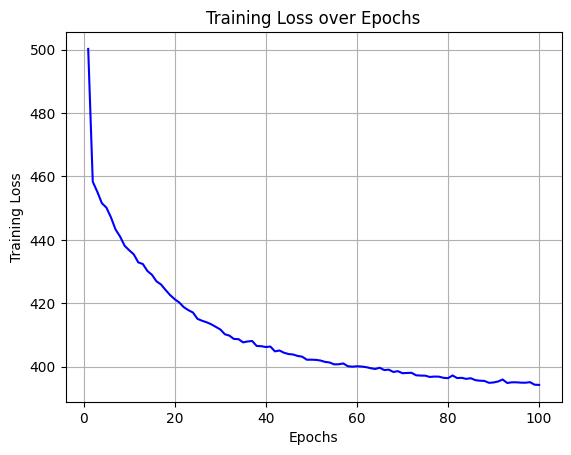

[500.22746677165657, 458.3513192095249, 455.1319969662534, 451.5627657856915, 450.13875669019853, 447.06376875864726, 443.2671597872483, 441.0212883045784, 438.1133045862411, 436.7039778249605, 435.4136116991381, 432.8620908877593, 432.3569713909381, 430.15356416148546, 428.9489549674496, 426.8823539903707, 425.8819952457909, 424.144094907795, 422.5311747404288, 421.2465926762519, 420.20771487892824, 418.72771837732375, 417.7900725277139, 417.0501492821881, 415.0503153568191, 414.4541623951192, 413.9723987138711, 413.35088446623797, 412.537071346189, 411.7117819666053, 410.1984327436233, 409.7620379292463, 408.70478659713194, 408.6544422572299, 407.63279424001655, 407.9203135529762, 408.0655194018997, 406.4921064445375, 406.42129470534013, 406.16467096223545, 406.3164343766118, 404.7925739644665, 405.063990752889, 404.351900688367, 403.94960838785033, 403.7979581857279, 403.3433777793917, 403.1117066262866, 402.153567555271, 402.16635222511655, 402.10684507398366, 401.9022387131571, 40

In [151]:
import matplotlib.pyplot as plt

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot the training loss
plt.plot(epochs, train_losses, 'b-')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

print(train_losses)

In [152]:
from mlp_utils import test_prediction_to_csv

test_prediction_to_csv(predictions, "mlp_encoding_layers_concatenated.csv", test_data)